## Chapter 10: Distance and Network Methods
### This notebook and the figures below are made by Yeseul Lee, under the guidance of Steven Skiena.

We say a distance measure is a metric if it satisfies the following properties:
• Positivity: d(x, y) ≥ 0 for all x and y.
• Identity: d(x,y) = 0 if and only if x = y.
• Symmetry: d(x, y) = d(y, x) for all x and y.
• Triangle inequality: d(x, y) ≤ d(x, z) + d(z, y) for all x, y, and z.

The Euclidean distance is a metric, which is why these conditions seem so natural to us. However, other equally-natural similarity measures are not distance metrics:
• Correlation coefficient: Fails positivity because it ranges from −1 to 1. Also fails identity, as the correlation of a sequence with itself is 1.
• Cosine similarity/dot product: Similar to correlation coefficient, it fails positivity and identity for the same reason.
• Travel times in a directed network: In a world with one-way streets, the distance from x to y is not necessarily the same as the distance from y to x.
• Cheapest airfare: This often violates the triangle inequality, because the cheapest way to fly from x to y might well involve taking a detour through z, due to bizarre airline pricing strategies.

\begin{equation} The L_k  Distance Metric\end{equation}

\begin{equation}
d_k(p,q)= k\sqrt{\left(\sum_{i=1}^d|p_i −q_i|\right)^k}=(\sum_{i=1}^d |p_i −q_i|^k)^{1/k}
\end{equation}

Manhattan distance (k = 1): City Block: The distance between two locations is then the sum of this north–south difference and the east–west difference. Everything is linear, so a difference of 1 in each of two dimensions is the same as a difference of 2 in only one dimension.


Euclidean distance (k = 2): offering more weight to the largest dimensional deviation without overwhelming the lesser dimensions. 
\begin{equation}
d(p,q)= \sqrt{\sum_{i=1}^d|p_i −q_i|^2}
\end{equation}

Maximum component (k = ∞): As the value of k increases, smaller kk
dimensional differences fade into irrelevance. If a > b, then a ≫ b . Taking the k^th root of a_k + b_k approaches a as b_k/a_k → 0. The L∞ metric returns the largest single dimensional difference as the distance.



In [2]:
from scipy import stats
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull

!pip install astroML


from astroML.clustering import HierarchicalClustering, get_graph_segments
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
 
import numpy as np
import matplotlib.pyplot as plt
import math, random
import pandas as pd
%matplotlib inline

  Stored in directory: C:\Users\mh0071\AppData\Local\pip\Cache\wheels\7c\f2\f3\eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


### Figure 10.2

The shape of circles defining equal distances changes with k. Consider the distance of points p1 = (2,0) and p2 = (2,1.99) from the
origin:
– For k = 1, the distances are 2 and 3.99, respectively. – For k = 2, they are 2 and 2.82136.
– For k = 1000, they are 2 and 2.00001.
– For k = ∞ , they are 2 and 2.

We are similarly comfortable with the notion that circles are round, because we live in an Euclidean space. A circle is defined as the collection of points which are at a distance r from an origin point p. Change the definition of distance, and you change the shape of a circle.

The shape of an L_k “circle” governs which points are equal neighbors about a center point p. Figure 10.2 illustrates how the shape evolves with k. Under Manhattan distance (k = 1), the circle looks like a diamond. For k = 2, it is the round object we are familiar with. For k = ∞, this circle stretches out to an axis-oriented box.

There is smooth transition from the diamond to the box as we vary 1 ≤ k ≤ ∞. Selecting the value of k is equivalent to choosing which circle best fits our domain model. The distinctions here become particularly important in higher dimensional spaces: do we care about deviations in all dimensions, or primarily the biggest ones?


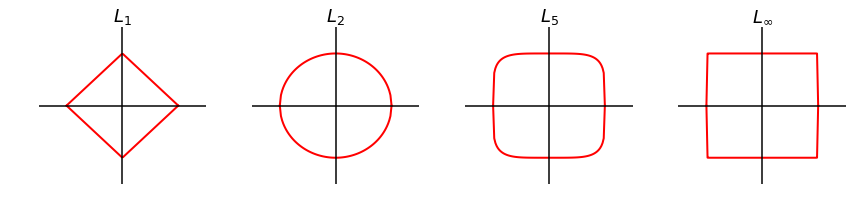

In [3]:
plt.figure(figsize=(12,3))

ax = plt.subplot(141)
x = np.linspace(-1,1,100)
y1 = 1 - np.abs(x)
y2 = -1 * y1
plt.plot(x, y1, 'r-', x, y2, 'r-', linewidth=2)
plt.plot([0,0], [-1.5,1.5], 'k-', [-1.5,1.5], [0,0], 'k-')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5) 
plt.axis("off")
plt.title(r"$L_1$", fontsize=18)

plt.subplot(142)
y1 = np.sqrt(1 - x*x)
y2 = -1 * y1
plt.plot(x, y1, 'r-', x, y2, 'r-', linewidth=2)
plt.plot([0,0], [-1.5,1.5], 'k-', [-1.5,1.5], [0,0], 'k-')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis("off")
plt.title(r"$L_2$", fontsize=18)

plt.subplot(143)
y1 = (1 - np.abs(x**5))**(0.2)
y2 = -1*y1
plt.plot(x, y1, 'r-', x, y2, 'r-', linewidth=2)
plt.plot([0,0], [-1.5,1.5], 'k-', [-1.5,1.5], [0,0], 'k-')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis("off")
plt.title(r"$L_5$", fontsize=18)

plt.subplot(144)
y1 = (1 - np.abs(x**100))**(0.01)
y2 = -1*y1
plt.plot(x, y1, 'r-', x, y2, 'r-', linewidth=2)
plt.plot([0,0], [-1.5,1.5], 'k-', [-1.5,1.5], [0,0], 'k-')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis("off")
plt.title(r"$L_\infty$", fontsize=18)

plt.tight_layout()

Selecting the right value of k can have a significant effect on the meaningfulness of your distance function, particularly in high-dimensional spaces.

Taking the kth root of the sum of kth-power terms is necessary for the resulting “distance” values to satisfy the metric property. However, in many applications we will be only using the distances for comparison: testing whether d(x, p) ≤ d(x, q) as opposed to using the values in formulas or isolation.

Because we take the absolute value of each dimensional distance before raising it to the kth power, the summation within the distance function always yields a positive value. The kth root/power function is monotonic, meaning that for x,y,k ≥ 0

\begin{equation}
(x>y)→(x^k >y^k).
\end{equation}

Thus the order of distance comparison is unchanged if we do not take the kth root of the summation. Avoiding the kth root calculation saves time, which can prove non-trivial when many distance computations are performed, as in nearest neighbor search.

## 10.2 Nearest Neighbor Classification

There are three big advantages to nearest neighbor methods for classification:
• Simplicity: Nearest neighbor methods are not rocket science; there is no math here more intimidating than a distance metric. This is important, because it means we can know exactly what is going on and avoid being the victim of bugs or misconceptions.
• Interpretability: Studying the nearest-neighbors of a given query point q explains exactly why the classifier made the decision it did. If you disagree with this outcome, you can systematically debug things. Were the neighboring points incorrectly labeled? Did your distance function fail to pick out the items which were the logical peer group for q?
• Non-linearity: Nearest neighbor classifiers have decision boundaries which are piecewise-linear, but can crinkle arbitrarily following the training ex- ample herd, as shown in Figure 10.3. From calculus we know that piecewise- linear functions approach smooth curves once the pieces get small enough. Thus nearest neighbor classifiers enable us to realize very complicated de- cision boundaries, indeed surfaces so complex that they have no concise representation.

### For Figure 10.3, preparing data
#### The source of the data set https://www.statcrunch.com/app/index.php?dataid=1406047
#### Reference: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#example-neighbors-plot-classification-py

Figure 10.3: The decision boundary of nearest-neighbor classifiers can be non- linear.


In [4]:
path = "weight.xls"
csv_data = pd.ExcelFile(path).parse('Sheet1')
female = csv_data[(csv_data['Gender'] == 0) & (csv_data['Age'] >=360) & (csv_data['Age'] <=480)] #Age is by the number of months. 20~40
male = csv_data[(csv_data['Gender'] == 1) & (csv_data['Age'] >=360) & (csv_data['Age'] <= 480)]

#Data
x = np.append(female['Weight'], male['Weight'])
y = np.append(female['Height'], male['Height'])
X = np.vstack((x,y)).T
h = .2  # step size in the mesh

#Make labels
a = np.empty(len(female))
a.fill(0)
b = np.empty(len(male))
b.fill(1)
Y = np.append(a, b)

#Fit the data
k = 1
c=neighbors.KNeighborsClassifier(k, weights='uniform')
c.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = c.predict(np.c_[xx.ravel(), yy.ravel()])

### Figure 10.3 Color space by the color of its nearest neighbor

Text(0,0.5,'Height(cm)')

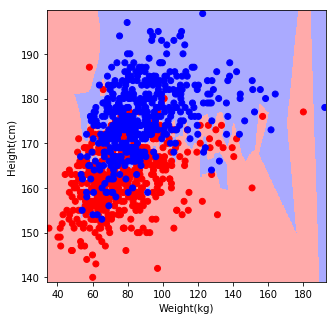

In [5]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5,5))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#Labels
plt.xlabel('Weight(kg)')
plt.ylabel('Height(cm)')

## 10.2.2 k-Nearest Neighbors
To classify a given query point q, nearest neighbor methods return the label of q′, the closest labeled point to q. This is a reasonable hypothesis, assuming that similarity in feature space implies similarity in label space. However, this classification is based on exactly one training example, which should give us pause.
More robust classification or interpolation follows from voting over multiple close neighbors. Suppose we find the k points closest to our query, where k is typically some value ranging from 3 to 50 depending upon the size of n. The arrangement of the labeled points coupled with the choice of k carves the feature space into regions, with all the points in a particular given region assigned the same label.

Consider Figure 10.4, which attempts to build a gender classifier from data


### Figure 10.4 Color space by the color of its nearest neighbor
From figure 10.3, figure 10.4 is just a simple modification away, which is to change the value of k.
The left figure has k = 3. The right figure has k = 10.

### Figure 10.5 Left - Voronoi diagram

Voronoi diagrams: For a set of target points, we would like to partition the space around them into cells such that each cell contains exactly one target point. Further, we want each cell’s target point to be the nearest target neighbor for all locations in the cell. Such a partition is called a Voronoi diagram, and is illustrated in Figure 10.5 (left).
The boundaries of Voronoi diagrams are defined by the perpendicular bisectors between pairs of points (a,b). Each bisector cuts the space in half: one half containing a and the other containing b, such that all points on a’s half are closer to a than b, and visa versa.
Voronoi diagrams are a wonderful tool for thinking about data, and have many nice properties. Efficient algorithms for building them and searching them exist, particularly in two dimensions. However, these procedures rapidly become more complex as the dimensionality increases, making them generally impractical beyond two or three dimensions.


Reference : http://scipy.github.io/devdocs/generated/scipy.spatial.Voronoi.html
http://scipy.github.io/devdocs/generated/scipy.spatial.voronoi_plot_2d.html

[]

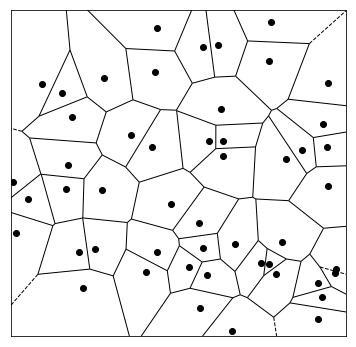

In [6]:
plt.rcParams['figure.figsize'] = 6,6

#generate 50 uniform points
x = np.random.rand(50,2) #2d array with 50 points
#find the voronoi
vor = Voronoi(x)
voronoi_plot_2d(vor, show_vertices=False)
plt.xlim(0,1)
plt.ylim(0,1)

#color the points black
plt.plot(x[:,0], x[:, 1], 'ko')

#Hide the x and y axis.
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])

Figure 10.5: Data structures for nearest neighbor search include Voronoi diagrams 

## 10.5 Clustering

Clustering is the problem of grouping points by similarity. Often items come from a small number of logical “sources” or “explanations”, and clustering is a good way to reveal these origins. Consider what would happen if an alien species were to come across height and weight data for a large number of hu- mans. They would presumably figure out that there seem to be two clusters representing distinct populations, one consistently bigger than the other. If the aliens were really on the ball, they might call these populations ‘men” and “women”. Indeed, the two height-weight clusters in Figure 10.11 are both highly concentrated in one particular gender.
Patterns on a two-dimensional dot plot are generally fairly easy to see, but we
often deal with higher-dimensional data that humans cannot effectively visual- ize. Now we need algorithms to find these patterns for us. Clustering is perhaps the first thing to do with any interesting data set. 

### Figure 10.11 - K-means
#### The source of the data set https://www.statcrunch.com/app/index.php?dataid=1406047
Figure 10.11: Clustering people in weight-height space, using 2-means clustering. The left cluster contains 240 women and 112 men, while the right cluster contains 174 men to 54 women. Compare this to the logistic regression classifier trained on this same data set, in Figure 9.17, in which the red region contained 229 women and only 63 men, while the blue region contained 223 men to 65 women.


[[ 97.65482456 172.71929825]
 [ 69.02926136 161.4375    ]]


Text(0.5,1,'K-Means Clustering')

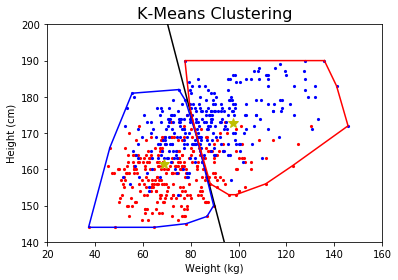

In [7]:
plt.figure(figsize=(6,4))
female = csv_data[(csv_data['Gender'] == 0) & (csv_data['Age'] >=800) & (csv_data['Age'] <=900)] #Age is by the number of months. 20~40
male = csv_data[(csv_data['Gender'] == 1) & (csv_data['Age'] >=800) & (csv_data['Age'] <= 900)]

plt.scatter(female['Weight'], female['Height'], c='red', s=10, lw=0)
plt.scatter(male['Weight'], male['Height'], c='blue', s=10, lw=0)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")

y = np.append(female["Height"], male["Height"])
x = np.append(female["Weight"], male["Weight"])

z = [[i,j] for i,j in zip(x,y)]
algo = KMeans(n_clusters=2)
algo.fit(z)
label = algo.labels_
centers = algo.cluster_centers_
print (centers)
plt.plot(centers[:,0], centers[:,1], 'y*', markersize=10)

#Find the perpendicular bisector
midpoint = [(centers[0][0]+centers[1][0])/2.0 , (centers[0][1] + centers[1][1])/2.0]
lineslope = (centers[0][1]-centers[1][1])/(centers[0][0]-centers[1][0])
perslope = -1/lineslope
perx = [60,100]
pery = perslope*(perx - midpoint[0]) + midpoint[1]
plt.plot(perx, pery, 'k-')

#Draw the convex hull instead.
division1 = [i for i,c in zip(z, label) if c == 1]
division1= np.array(division1)
division2 = [i for i,c in zip(z, label) if c == 0]
division2 = np.array(division2)
hull1 = ConvexHull(division1)
hull2 = ConvexHull(division2)

# to make the line come back to the first point, I appended the first vertice to it at last.
plt.plot(np.append(division1[hull1.vertices, 0], division1[hull1.vertices[0],0]), \
         np.append(division1[hull1.vertices,1], division1[hull1.vertices[0],1]),'b-', linewidth=1.5)
plt.plot(np.append(division2[hull2.vertices, 0], division2[hull2.vertices[0],0]), \
         np.append(division2[hull2.vertices,1], division2[hull2.vertices[0],1]),'r-', linewidth=1.5)
plt.xlim(20,160)
plt.ylim(140,200)
plt.title("K-Means Clustering", fontsize=16)

### For Figure 10.12

Clustering is an inherently ill-defined problem, since proper clusters depend upon context and the eye of the beholder. Look at Figure 10.12. How many different clusters do you see there? Some see three, other see nine, and others vote for pretty much any number in between.
How many clusters you see depends somewhat upon how many clusters you want to see. People can be clustered into two groups, the lumpers and the splitters, depending upon their inclination to make fine distinctions. Splitters look at dogs, and see poodles, terriers, and cocker spaniels. Lumpers look at dogs, and see mammals. Splitters draw more exciting conclusions, while lumpers are less likely to overfit their data. Which mindset is most appropriate depends upon your task.



In [8]:
#Data set
size = 20
x1 = np.random.sample([size]) +2
noise = np.random.normal(2,0.3, size)
y1 = [10]*size + noise

x2 = np.random.sample([size]) +5
noise = np.random.normal(1,0.3, size)
y2 = [8]*size + noise

x3 = np.random.sample([size]) +5
noise = np.random.normal(1,0.3, size)
y3 = [14]*size + noise

x4 = np.random.sample([size]) +7
noise = np.random.normal(1,0.3, size)
y4 = [11]*size + noise

size=100
x5 = np.random.sample([size])*4 + 9
noise = np.random.normal(1,0.1, size)
y5 = [5.9]*size + noise

x6 = np.random.sample([size])*4 + 9
noise = np.random.normal(1,0.1, size)
y6 = [4]*size + noise

x7 = np.random.sample([size])*4 + 9
noise = np.random.normal(1,0.1, size)
y7 = [2.1]*size + noise

x8 = np.linspace(-2,2,30)
f1 = [np.sqrt(4 - i*i) for i in x8]
f1 = np.array(f1)
f2 = -1 * f1

x8 = np.append(x8, x8) +14
y8 = np.append(f1, f2) + 14

x = np.append(x8,y8)
y8 = np.append(y8,x8)
x8 = x

x9 = np.random.sample([size]) +13.5
noise = np.random.normal(1,0.3, size)
y9 = [13]*size + noise

xlst = [x1, x2, x3, x4, x5, x6, x7, x8, x9]
ylst = [y1, y2, y3, y4, y5, y6, y7, y8, y9]
x = []
y = []
for i in xlst:
    x = np.append(x, i)
for j in ylst:
    y = np.append(y, j)
    
X = [[i,j] for i,j in zip(x, y)]
X = np.array(X)

### Figure 10.12

In [9]:
k

1

(1, 18)

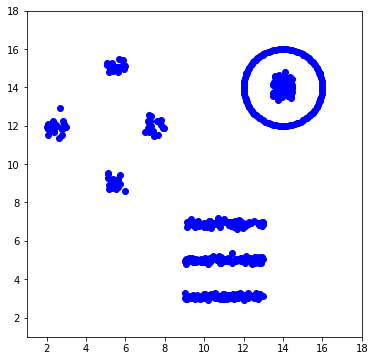

In [10]:
plt.figure(figsize=(6,6))
plt.plot(x, y, 'bo')
plt.xlim(1,18)
plt.ylim(1,18)

### For Figure 10.14, 

Figure 10.14 presents an animation of k-means in action. The initial guesses for the cluster centers are truly bad, and the initial assignments of points to centers splits the real clusters instead of respecting them. But the situation rapidly improves, with the centroids drifting into positions that separates the points in the desired way. Note that the k-means procedure does not necessar- ily terminate with the best possible set of k centers, only at a locally-optimal solution that provides a logical stopping point. It is a good idea to repeat the entire procedure several times with different random initializations and accept the best clustering found over all. The mean squared error is the sum of squares of the distance between each point Pi and its center Cj, divided by the number of points n. The better of two clusterings can be identified as having lower mean squared error, or some other reasonable error statistic.

In [12]:
def initialize_centroids(points, k):
    centroids = random.sample(list(points), k)
    centroids = np.array(centroids)
    return centroids

# Define the function to find the closest centroid for each point.
def closest_centroid(points, centroids):
    closest = []
    for i in range(0,len(points)):
        k = []
        for j in range(0, len(centroids)):
            k.append(np.sqrt((points[i,0]-centroids[j,0])**2 + (points[i,1]-centroids[j,1])**2))
        closest.append(np.argmin(k))
    return closest

# Define a function for finding the average points of the points assigned to each centroid.
def average_points(points, centroids, cluster):
    result=[]
    for i in range(0, len(centroids)):
        pointsByCluster = []
        for j in range(0,len(cluster)):
            if cluster[j] == i:
                pointsByCluster.append(points[j])
        pointsByCluster=np.array(pointsByCluster)
        result.append([sum(pointsByCluster[:,0])/len(pointsByCluster), \
                       sum(pointsByCluster[:,1])/len(pointsByCluster)])
    return result
                

### Figure 10.14 - Initialization for k-means clustering animation


In [13]:
# Initialize k number of centroids
k = 5
random.seed(7)
centroids = initialize_centroids(X,k)
#Nearest points to the centroid.
nearest = closest_centroid(X, centroids)

centroids = np.array(average_points(X, centroids, nearest ))

### Figure 10.14 - The iterations of K-means

Text(7,17,'Iteration 7')

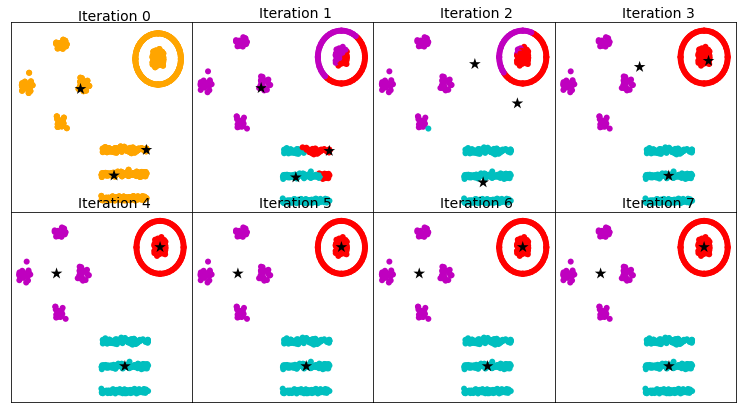

In [14]:
plt.rcParams['figure.figsize'] = 13,7
fig, ax = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0, hspace=0) #Adjust the whitespace between subplots

k=3
random.seed(4)
colors=["red", "m", "c"]
textx = 7
texty = 17

#Just the dots
ax[0,0].scatter(X[:, 0], X[:, 1], color='orange', edgecolor="")
#Add the centroids
ax[0,0].scatter(X[:, 0], X[:, 1], color='orange', edgecolor="")
centroids = initialize_centroids(X,k)
ax[0,0].scatter(centroids[:, 0], centroids[:, 1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[0,0].axes.get_xaxis().set_visible(False)
ax[0,0].axes.get_yaxis().set_visible(False)
ax[0,0].text(textx,texty, "Iteration 0", fontsize=14)

#Classify by the nearest centroid
#Nearest points to the centroid.
nearest = closest_centroid(X, centroids)
ax[0,1].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[0,1].scatter(centroids[:,0], centroids[:,1], color='black',marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[0,1].axes.get_xaxis().set_visible(False)
ax[0,1].axes.get_yaxis().set_visible(False)
ax[0,1].text(textx,texty, "Iteration 1", fontsize=14)


#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[0,2].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[0,2].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[0,2].axes.get_xaxis().set_visible(False)
ax[0,2].axes.get_yaxis().set_visible(False)
ax[0,2].text(textx,texty, "Iteration 2", fontsize=14)


#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[0,3].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[0,3].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[0,3].axes.get_xaxis().set_visible(False)
ax[0,3].axes.get_yaxis().set_visible(False)
ax[0,3].text(textx,texty, "Iteration 3", fontsize=14)

#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[1,0].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[1,0].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[1,0].axes.get_xaxis().set_visible(False)
ax[1,0].axes.get_yaxis().set_visible(False)
ax[1,0].text(textx,texty, "Iteration 4", fontsize=14)

#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[1,1].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[1,1].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[1,1].axes.get_xaxis().set_visible(False)
ax[1,1].axes.get_yaxis().set_visible(False)
ax[1,1].text(textx,texty, "Iteration 5", fontsize=14)

#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[1,2].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[1,2].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[1,2].axes.get_xaxis().set_visible(False)
ax[1,2].axes.get_yaxis().set_visible(False)
ax[1,2].text(textx,texty, "Iteration 6", fontsize=14)

#Now move the centroids to the average points classified to.
centroids = np.array(average_points(X, centroids, nearest ))
#Classify by the nearest centroid again.
nearest = closest_centroid(X, centroids)
ax[1,3].scatter(X[:,0], X[:,1], c=[colors[i] for i in nearest], edgecolor="")
ax[1,3].scatter(centroids[:,0], centroids[:,1], color='black', marker="*", s=150, edgecolors="")
#Hide the x and y axis.
ax[1,3].axes.get_xaxis().set_visible(False)
ax[1,3].axes.get_yaxis().set_visible(False)
ax[1,3].text(textx,texty, "Iteration 7", fontsize=14)

### Figure 10.15

Figure 10.15: Running k-means for k = 1 to k = 9. The “right” clustering is found for k = 3, but the algorithm is unable to properly distinguish between nested circular clusters and long thin clusters for large k.


('error is ', 17843.477046899345, 'for k = ', 1)
('error is ', 6628.281323148067, 'for k = ', 2)
('error is ', 2231.667546844244, 'for k = ', 3)
('error is ', 1692.9810665011642, 'for k = ', 4)
('error is ', 1374.6446962085727, 'for k = ', 5)
('error is ', 1177.3527001322668, 'for k = ', 6)
('error is ', 1002.2890437760502, 'for k = ', 7)
('error is ', 861.3471458365782, 'for k = ', 8)
('error is ', 732.5597915290066, 'for k = ', 9)


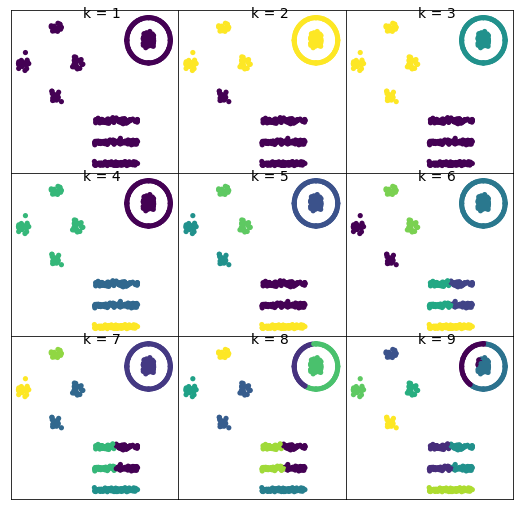

In [15]:
plt.rcParams['figure.figsize'] =9,9
fig, ax = plt.subplots(3, 3)
plt.subplots_adjust(wspace=0, hspace=0) #Adjust the whitespace between subplots
np.random.seed(10)

for i in range(0,3):
    for j in range(0,3):
        result = KMeans(n_clusters= (3*i+j+1))
        yprediction = result.fit_predict(X)
        inertia = result.inertia_
        print ('error is ', inertia, 'for k = ', 3*i+j+1)
        ax[i, j].scatter(X[:, 0], X[:, 1], c=yprediction, edgecolor='', s = 27)
        title = 'k = ' +  str(3*i+j+1)
        ax[i, j].text(8, 16, title, fontsize=14)
        #Hide the x and y axis.
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)

### For Figure 10.16, 

The easiest way to find the right k is to try them all, and then pick the best one. Starting from k = 2 to as high as you feel you have time for, perform k-means and evaluate the resulting clustering according to the mean squared error (MSE) of the points from their centers. Plotting this yields an error curve, as shown in Figure 10.16. The error curve for random centers is also provided.
Both error curves show the MSE of points from their centers decreasing as we allow more and more cluster centers. But the wrong interpretation would be to suggest we need k as large as possible, because the MSE should decrease when allowing more centers. Indeed, inserting a new center at a random position r into a previous k-means solution can only decrease the mean squared error, by happening to land closer to a few of the input points than their previous center. This carves out a new cluster around r, but presumably an even better clustering would have been found running by k-means from scratch on (k + 1) centers.
What we seek from the error curve in Figure 10.16 is the value k where the rate of decline decreases, because we have exceeded number of true sources, and so each additional center is acting like a random point in the previous discussion. The error curve should look something like an arm in typing position: it slopes down rapidly from shoulder to elbow, and then slower from the elbow to the wrist. We want k to be located exactly at the elbow. This point might be easier to identify when compared to a similar MSE error plot for random centers, since the relative rate of error reduction for random centers should be analogous to what we see past the elbow. The slow downward drift is telling us the extra clusters are not doing anything special for us.



In [16]:
# Define the function to find the closest centroid for each point and the sum of squared distance to it.
def sum_of_sqrd_dist(points, centroids):
    distance = []
    closest = []
    for i in range(0,len(points)):
        k = []
        for j in range(0, len(centroids)):
            #a**2 + b**2 = c**2
            k.append((points[i,0]-centroids[j,0])**2 + (points[i,1]-centroids[j,1])**2)
        distance.append(min(k))
    return sum(distance)

#random numbers for centroids.
def initialize_centroids_random(k):
    rlist = []
    for i in range(k):
        rlist.append([random.uniform(0,18), random.uniform(0,18)])
    centroids = np.array(rlist)
    return centroids

### Data points for Figure 10.16

In [17]:
#This is for calculation of MSE (or to be correct the Absolute Error)
errorlist = []
for i in range(1,13):
    result = KMeans(n_clusters=i)
    yprediction = result.fit_predict(X)
    errorlist.append(result.inertia_)
print (errorlist)

#For calculating sum of squared distance to random centers.
#And the mean of 5 different ones.
random_errorlist = []
num_runs = 30
for i in range(1,13):
    value = 0
    for j in range(num_runs):
        centroids = initialize_centroids_random(i)
        sum_dist = sum_of_sqrd_dist(X, centroids)
        value += sum_dist
    random_errorlist.append(value/float(num_runs))
print (random_errorlist)

[17843.477046899345, 6628.281323148067, 2231.667546844244, 1692.9810665011642, 1395.449621011769, 1193.3927858380598, 1005.6383970385297, 860.3090255455177, 728.5173496925036, 627.6392766837662, 516.9609225832914, 433.89374703001965]
[54853.36843559598, 38767.87236855143, 20940.896806710043, 16203.970494138863, 12794.426432230975, 10400.905540523954, 9439.337375710678, 7199.397098008175, 7315.7591317435, 6309.45720443515, 5267.97273083293, 4479.864319791451]


### Figure 10.16 - Error Curve

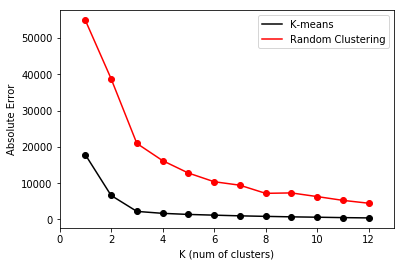

In [18]:
e = errorlist

e2 = random_errorlist

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

plt.rcParams['figure.figsize'] = 6,4
plt.plot(x,e, 'k-', linewidth='1.5', label='K-means')
plt.plot(x,e, 'ko')
plt.plot(x,e2, 'r-', linewidth='1.5', label='Random Clustering')
plt.plot(x,e2, 'ro')

plt.xlim(0,13)

plt.xlabel('K (num of clusters)')
plt.ylabel('Absolute Error')
plt.legend()

## Building Agglomerative Cluster Trees
The basic agglomerative clustering algorithm is simple enough to be described in two sentences. Initially, each item is assigned to its own cluster. Merge the two closest clusters into one by putting a root over them, and repeat until only one cluster remains.

how to compute the distance between clusters: Use L2 for example.

there are several reasonable answers for the distance between two non-trivial clusters, which lead to different trees on the same input, and can have a profound impact on the shape of the resulting clusters. The leading candidates, illustrated in Figure 10.18, are:

Nearest neighbor (single link): Here the distance between clusters C1 and C2 is defined by the closest pair of points spanning them:

\begin{equation}
d(C_1, C_2) = min_{x∈C_1,y∈C_2} ||x − y|| 
\end{equation}

Using this metric is called single link clustering, because the decision to merge is based solely on the single closest link between the clusters.
The minimum spanning tree of a graph G is tree drawn from the edges of G connecting all vertices at lowest total cost. Agglomerative clustering with the single link criteria is essentially the same as Kruskal’s algorithm, which creates the minimum spanning tree (MST) of a graph by repeatedly adding the lowest weight edge remaining which does not create a cycle in the emerging tree.

The connection between the MST (with n nodes and n − 1 edges) and the cluster tree (with n leaves, n − 1 internal nodes, and 2n − 2 edges) is somewhat subtle: the order of insertion edges in the MST from smallest to largest describes the order of merging in the cluster tree, as shown in Figure 10.20.

The Platonic ideal of clusters are as compact circular regions, which generally radiate out from centroids, as in k-means clustering. By contrast, single-link clustering tends to create relatively long, skinny clusters, be- cause the merging decision is based only on the nearness of boundary points. Single link clustering is fast, but tends to be error prone, as out- lier points can easily suck two well-defined clusters together.
• Average link: Here we compute distance between all pairs of cluster- spanning points, and average them for a more robust merging criteria than single-link:

\begin{equation}
d(C_1, C_2) = \frac1{|C_1||C_2|} \sum_{x∈C_1} \sum_{y∈C_2} ||x − y||
\end{equation}

This will tend to avoid the skinny clusters of single-link, but at a greater computational cost. The straightforward implementation of average link clustering is O(n3), because each of the n merges will potentially require touching O(n2) edges to recompute the nearest remaining cluster. This is n times slower than single link clustering, which can be implemented in O(n2) time.

• Nearest centroid: Here we maintain the centroid of each cluster, and merge the cluster-pair with the closest centroids. This has two main ad- vantages. First, it tends to produce clusters similar to average link, be- cause outlier points in a cluster get overwhelmed as the cluster size (num- ber of points) increases. Second, it is much faster to compare the centroids of the two clusters than test all |C1||C2| point-pairs in the simplest imple- mentation. Of course, centroids can only be computed for records with all numerical values, but the algorithm can be adapted to use the centermost point in each cluster (medioid) as a representative in the general case.

• Furthest link: Here the cost of merging two clusters is the farthest pair of points between them:

\begin{equation}
d(C1,C2)= max_{x∈C1,y∈C2} ||x−y||
\end{equation}



### For Figure 10.18

Figure 10.18: Four distance measures for identifying the nearest pair of clusters.

In [19]:
def minDistance(L1, L2):
    min = float("inf")
    minvalues = []
    for i in L1:
        for j in L2:
            k = np.sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2)
            if k <= min:
                min = k
                minvalues = (i,j)
    return minvalues

def maxDistance(L1, L2):
    max = 0
    maxvalues = []
    for i in L1:
        for j in L2:
            k = np.sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2)
            if k >= max:
                max = k
                maxvalues = (i,j)
    return maxvalues

### Figure 10.18

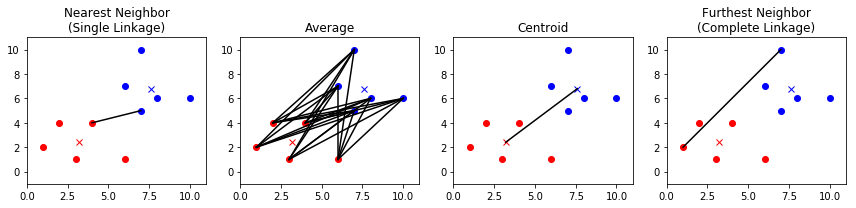

In [20]:
reds = [[1,2],[2,4],[3,1],[4,4],[6,1]]
reds = np.array(reds)
blues = [[6,7], [7,5], [8,6], [7,10], [10,6]]
blues = np.array(blues)
centroidx = [np.mean(reds[:,0]), np.mean(blues[:,0])]
centroidy = [np.mean(reds[:,1]), np.mean(blues[:,1])]

plt.figure(figsize=(12,3))
plt.subplot(141)
plt.plot(reds[:,0], reds[:,1], 'ro', blues[:,0], blues[:,1], "bo",\
        centroidx[0], centroidy[0], 'rx', centroidx[1],centroidy[1], 'bx')
plt.xlim(0,11)
plt.ylim(-1,11)
d = minDistance(reds, blues)
d = np.array(d)
plt.plot(d[:,0], d[:,1], 'k-')
plt.title("Nearest Neighbor\n(Single Linkage)")

plt.subplot(142)
plt.plot(reds[:,0], reds[:,1], 'ro', blues[:,0], blues[:,1], "bo",\
        centroidx[0], centroidy[0], 'rx', centroidx[1],centroidy[1], 'bx')
plt.xlim(0,11)
plt.ylim(-1,11)
for i in reds:
    for j in blues:
        x = [i[0], j[0]]
        y = [i[1], j[1]]
        plt.plot(x, y, 'k-')
plt.title("Average")

plt.subplot(143)
plt.plot(reds[:,0], reds[:,1], 'ro', blues[:,0], blues[:,1], "bo",\
        centroidx[0], centroidy[0], 'rx', centroidx[1],centroidy[1], 'bx')
plt.xlim(0,11)
plt.ylim(-1,11)
plt.plot(centroidx,centroidy,'k-')
plt.title("Centroid")

plt.subplot(144)
plt.plot(reds[:,0], reds[:,1], 'ro', blues[:,0], blues[:,1], "bo",\
        centroidx[0], centroidy[0], 'rx', centroidx[1],centroidy[1], 'bx')
plt.xlim(0,11)
plt.ylim(-1,11)
d = maxDistance(reds, blues)
d = np.array(d)
plt.plot(d[:,0], d[:,1], 'k-')
plt.title("Furthest Neighbor\n(Complete Linkage)")
plt.tight_layout()

### Figure 10.19 Left

Figure 10.19: Single linkage clustering is equivalent to finding the minimum spanning tree of a network.


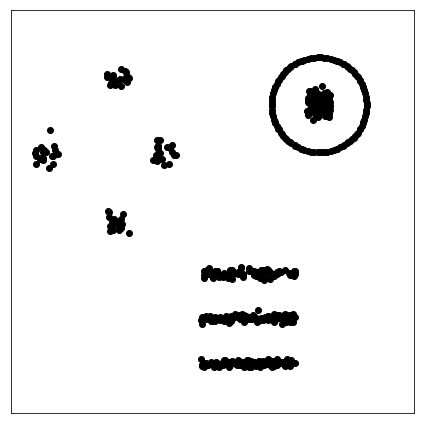

In [21]:
plt.figure(frameon=False, figsize=(6,6))

plt.plot(X[:,0], X[:,1], 'ko', linewidth=1)

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim(1,18)
plt.ylim(1,18)
plt.tight_layout()

### For Figure 10.19 Right
#### Source: http://www.astroml.org/book_figures/chapter6/fig_great_wall_MST.html

In [22]:
# Get the x, y coordinates of the beginning and end of each line segment
n_neighbors = 9
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=100)
model.fit(X)
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)



### Figure 10.19 Right

Figure 10.19: Single linkage clustering is equivalent to finding the minimum spanning tree of a network.



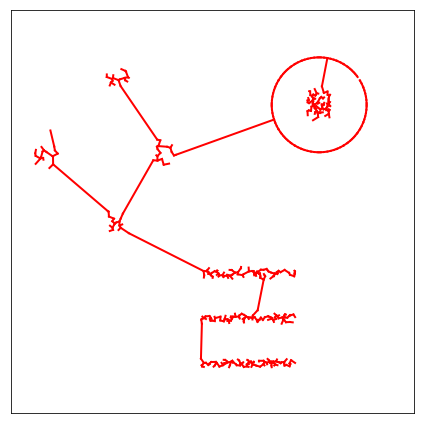

In [23]:
plt.figure(figsize=(6,6))

plt.plot(T_x, T_y, 'r-', linewidth=2)

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim(1,18)
plt.ylim(1,18)
plt.tight_layout()

## 10.5.4 Similarity Graphs and Cut-Based Clustering

It is a common practice to try several clustering algorithms on the same data set, and use the one which looks best for our purposes. The clusterings produced by two different algorithms should be fairly similar if both algorithms are doing reasonable things, but it is often of interest to measure exactly how similar they are. This means we need to define a similarity or distance measure on clusterings.
Every cluster is defined by a subset of items, be they points or records. The Jaccard similarity J (s1 , s2 ) of sets s1 and s2 is defined as the ratio of their
intersection and union:
\begin{equation}
J(s_1,s_2)= \frac{|s_1 ∩ s_2|}{|s_1 ∪ s_2|}
\end{equation}

This similarity measure can be turned into a proper distance metric d(s1, s2) called the Jaccard distance, where
\begin{equation}
d(s_1 , s_2 ) = 1 − J (s_1 , s_2 )
\end{equation}
### Figure 10.21 Left

Figure 10.21: The results of k-means (left) and cut-based spectral clustering (right) on our 9-cluster example. Spectral clustering correctly finds connected clusters here that k-means cannot.


To come up with the reasonable answer of nine clusters, your internal clustering algorithm had to manage tricks like classifying a ring around a central blob as two distinct clusters, and avoid merging two lines that move suspiciously close to each other. k-means doesn’t have a chance of doing this, as shown in Figure 10.21 (left), because it always seeks circular clusters and is happy to split long stringy clusters. Of the agglomerative clustering procedures, only single-link with exactly the right threshold might have a chance to do the right thing, but it is easily fooled into merging two clusters by a single close point pair.

An n × n similarity matrix S scores how much alike each pair of elements pi and pj are. Similarity is essentially the inverse of distance: when pi is close to pj, then the item associated with pi must be similar to that of pj. It is natural to measure similarity on a scale from 0 to 1, where 0 represents completely different and 1 means identical. This can be realized by making S[i, j] an inverse exponential function of distance, regulated by a parameter β:
\begin{equation}
S[i,j] = e^{−β||pi−pj||}
\end{equation}

This works because 

\begin{equation}
e^0 =1
\end{equation}
and
\begin{equation}
e^{−x} =\frac1{e^x} →0 
\end{equation}

as x→∞.


A similarity graph has a weighted edge (i,j) between each pair of vertices i
and j reflecting the similar of pi and pj. This is exactly the similarity matrix described above. However, we can make this graph sparse by setting all small terms (S[i, j] ≤ t for some threshold t) to zero. This greatly reduces the number of edges in the graph. We can even turn it into an unweighted graph by setting the weight to 1 for all S[i,j] > t.

Cuts in Graphs
Real clusters in similarity graphs have the appearance of being dense regions which are only loosely connected to the rest of graph. A cluster C has a weight which is a function of the edges within the cluster:
\begin{equation}
W(C) = \sum_{x∈C} \sum_{y∈C}S[i,j]
\end{equation}

Text(0.5,1,'K-Means')

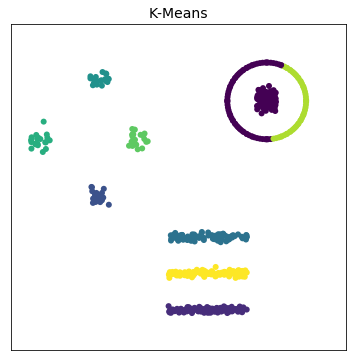

In [24]:
plt.figure(figsize=(6,6))
algo = KMeans(n_clusters=9)
algo.fit(X)
label = algo.labels_

plt.scatter(X[:,0], X[:,1], c=label, edgecolor="")

plt.xlim(1,18)
plt.ylim(1,18)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("K-Means", fontsize=14)

### Figure 10.21 Right

Text(0.5,1,'Spectral Clustering')

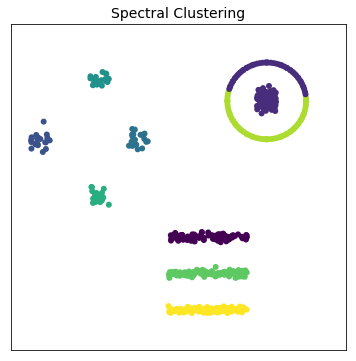

In [25]:
plt.figure(figsize=(6,6))
algo = SpectralClustering(n_clusters=9)
algo.fit(X)
label = algo.labels_

plt.scatter(X[:,0], X[:,1], c=label, edgecolor="")

plt.xlim(1,18)
plt.ylim(1,18)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Spectral Clustering", fontsize=14)